In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from loaders.ultrasound_dataset import USDataset

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import SimpleITK as sitk
import numpy as np

import pickle

In [27]:
mount_point = '/work/jprieto/data/remote/GWH/Groups/FAMLI/Shared/C1_ML_Analysis'
df_test = pd.read_csv(os.path.join(mount_point, 'CSV_files', 'c1_volumes_ga_boe_20220811_masked_resampled_128_spc075_notna_clean_test.csv'))

feat_fn = os.path.join(mount_point, 'test_output/ga3d/', 'GANet3DB3/epoch=654-val_loss=5.55/c1_volumes_ga_boe_20220811_masked_resampled_128_spc075_notna_clean_test.pickle')
x, x_a, x_s, x_v, x_v_p = pickle.load(open(feat_fn, 'rb'))

In [28]:
ga_column = 'ga_boe'
id_column = 'StudyID'

df_groups = df_test.groupby(id_column)
df_g = []
for k in df_groups.groups.keys():
    df_group = df_groups.get_group(k)
    ga = float(df_group[ga_column].unique()[0])
    study_dttm = df_group['study_dttm'].unique()[0]
    Manufacturer = df_group['Manufacturer'].unique()[0]
    df_g.append({id_column: k, ga_column: ga, 'study_dttm': study_dttm, 'Manufacturer': Manufacturer})
df_g = pd.DataFrame(df_g)

df_g['pred'] = x.reshape(-1)
df_g['error'] = df_g['pred'] - df_g[ga_column]
df_g['abs'] = abs(df_g['error'])

In [31]:
df_g = df_g.query('ga_boe > 98')
df_g['abs'].describe(percentiles=[.25, .5, .75, .95, .99])

count    545.000000
mean       5.893057
std        5.402133
min        0.017574
25%        1.992043
50%        4.538864
75%        7.894699
95%       15.986855
99%       25.180439
max       39.886970
Name: abs, dtype: float64

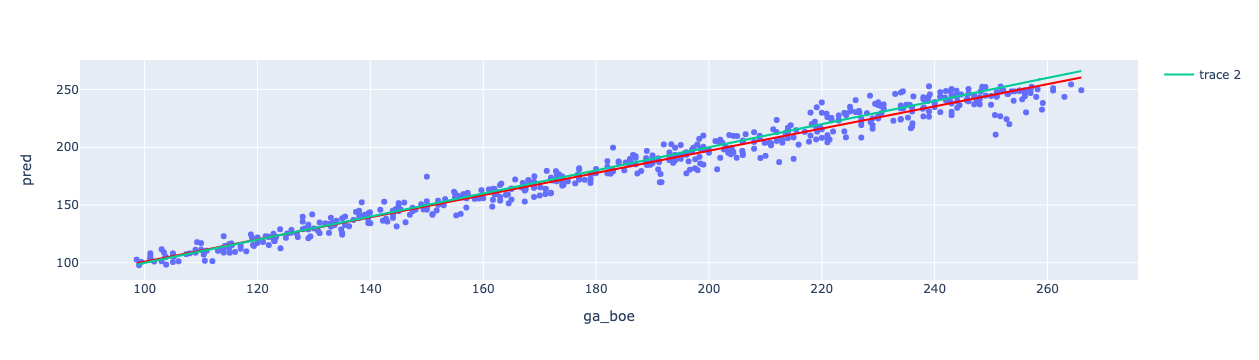

In [39]:
fig = px.scatter(df_g, x="ga_boe", y="pred", trendline='ols', trendline_color_override="red")
fig.add_trace(go.Scatter(x=df_g["ga_boe"], y=df_g["ga_boe"]))
fig

In [33]:
df_g['trimester'] = (df_g['ga_boe'] >= 196) + 2

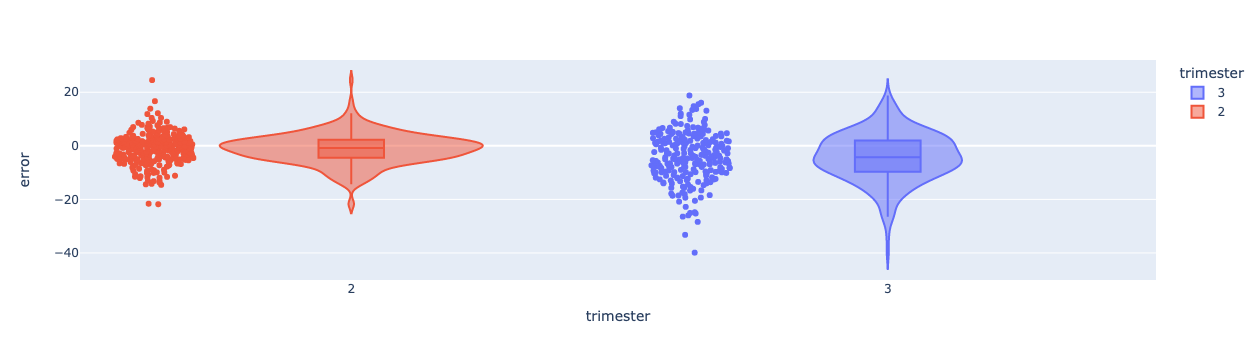

In [34]:
fig = px.violin(df_g, y="error", x='trimester', color="trimester", box=True, points="all")
fig

In [35]:
df_st = df_g.query('ga_boe < 196')
df_st['abs'].describe(percentiles=[.25, .5, .75, .95, .99])

count    297.000000
mean       4.351533
std        3.867777
min        0.017574
25%        1.535073
50%        3.360235
75%        5.961014
95%       11.857636
99%       16.858985
max       24.537994
Name: abs, dtype: float64

In [36]:
df_tt = df_g.query('ga_boe >= 196')
df_tt['abs'].describe(percentiles=[.25, .5, .75, .95, .99])

count    248.000000
mean       7.739155
std        6.329847
min        0.058212
25%        3.281072
50%        6.204239
75%       10.556328
95%       19.147830
99%       27.474546
max       39.886970
Name: abs, dtype: float64